<a href="https://colab.research.google.com/github/sielerod/Heart_Failure/blob/master/heart_failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de Falhas no Coração

Fonte:
https://www.kaggle.com/andrewmvd/heart-failure-clinical-data/notebooks


In [1]:
import pandas as pd

In [9]:
url = 'https://raw.githubusercontent.com/sielerod/Heart_Failure/master/Data/heart_failure_clinical_records_dataset.csv'
heart_failure = pd.read_csv(url)
heart_failure.head(3)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1


In [40]:
heart_failure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


## Exploração de dados

Table 1 Meanings, measurement units, and intervals of each feature of the dataset

https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5/tables/1

In [10]:
heart_failure.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


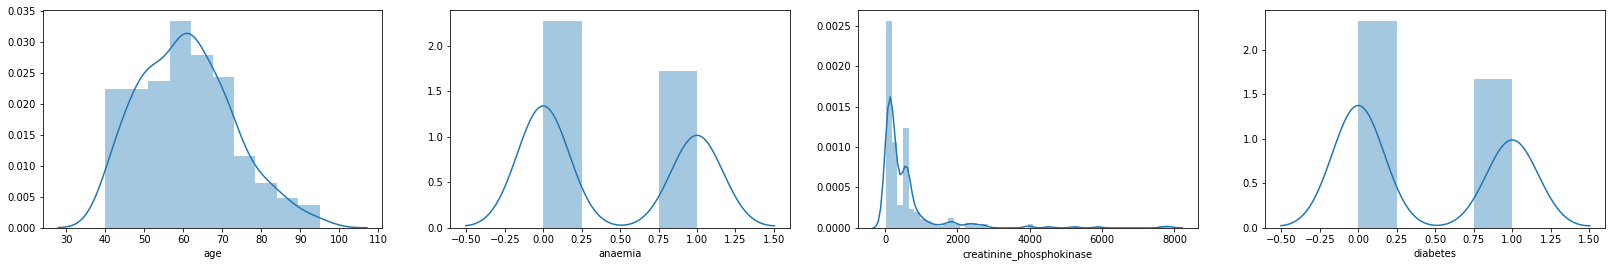

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.distplot(heart_failure['age'], ax=axes[0])
sns.distplot(heart_failure['anaemia'], ax=axes[1])
sns.distplot(heart_failure['creatinine_phosphokinase'], ax=axes[2])
sns.distplot(heart_failure['diabetes'], ax=axes[3])


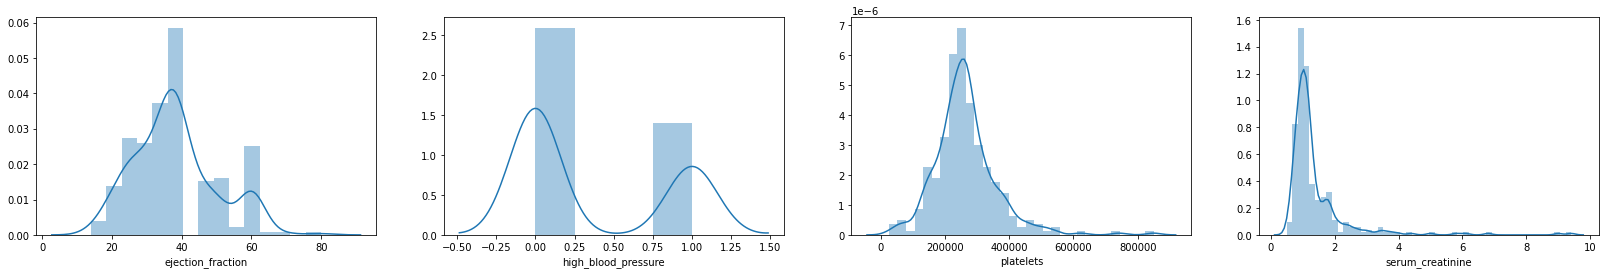

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 4))

sns.distplot(heart_failure['ejection_fraction'], ax=axes[0])
sns.distplot(heart_failure['high_blood_pressure'], ax=axes[1])
sns.distplot(heart_failure['platelets'], ax=axes[2])
sns.distplot(heart_failure['serum_creatinine'], ax=axes[3])


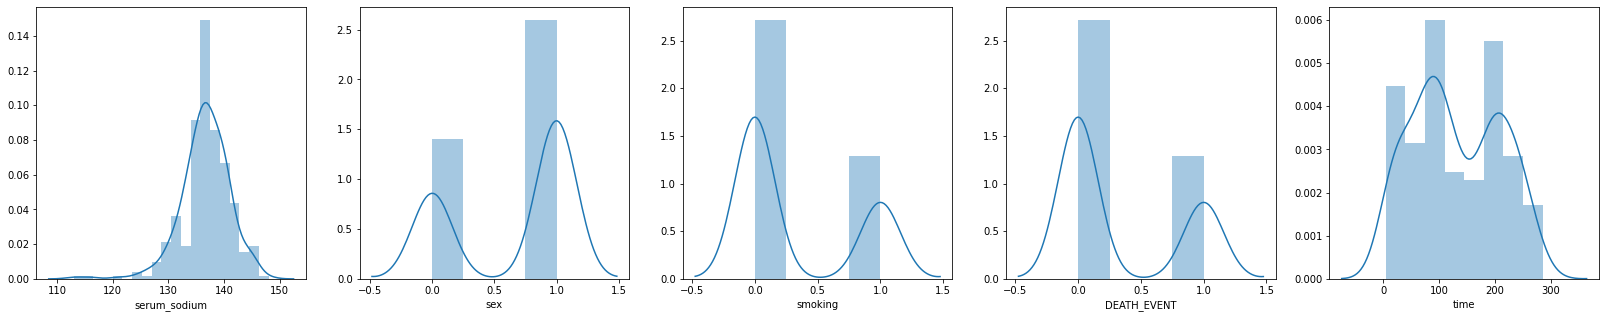

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(28, 5))

sns.distplot(heart_failure['serum_sodium'], ax=axes[0])
sns.distplot(heart_failure['sex'], ax=axes[1])
sns.distplot(heart_failure['smoking'], ax=axes[2])
sns.distplot(heart_failure['DEATH_EVENT'].dropna(), ax=axes[3])
sns.distplot(heart_failure['time'].dropna(), ax=axes[4])


In [18]:
import plotly.express as px

fig = px.histogram(heart_failure, x="age", color="anaemia")
fig.show()

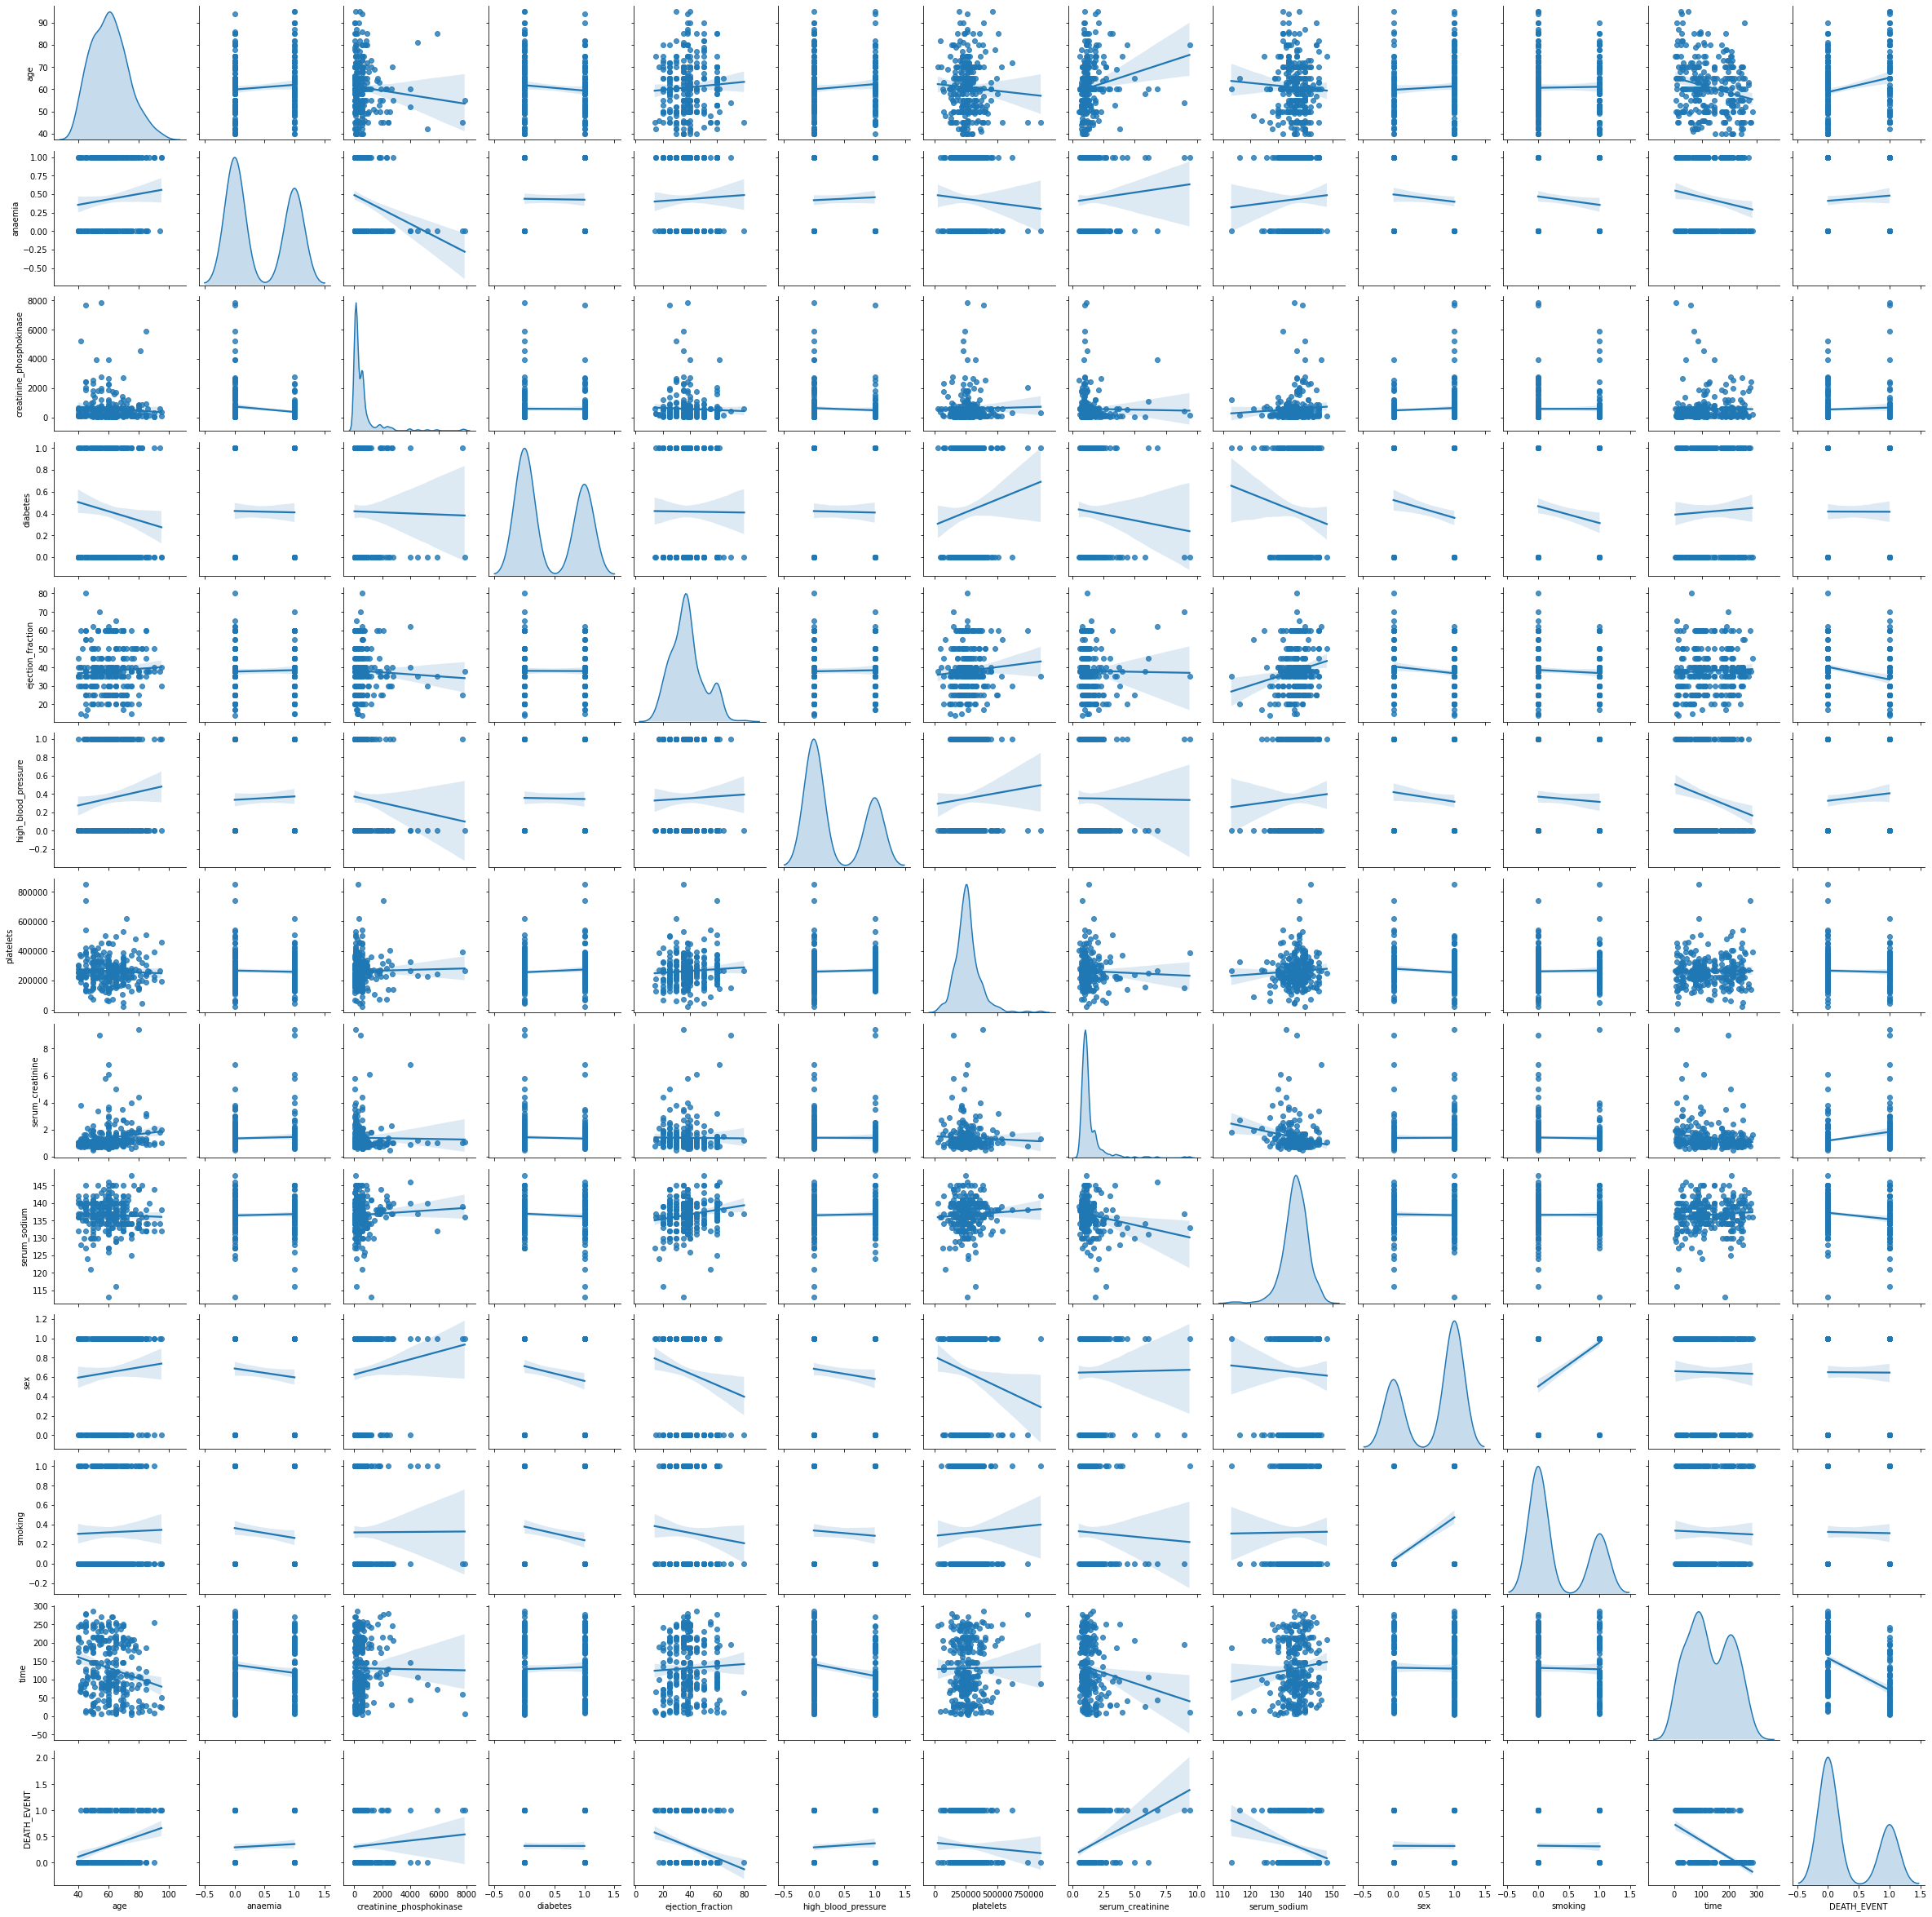

In [27]:
_ = sns.pairplot(heart_failure, kind='reg', diag_kind='kde')

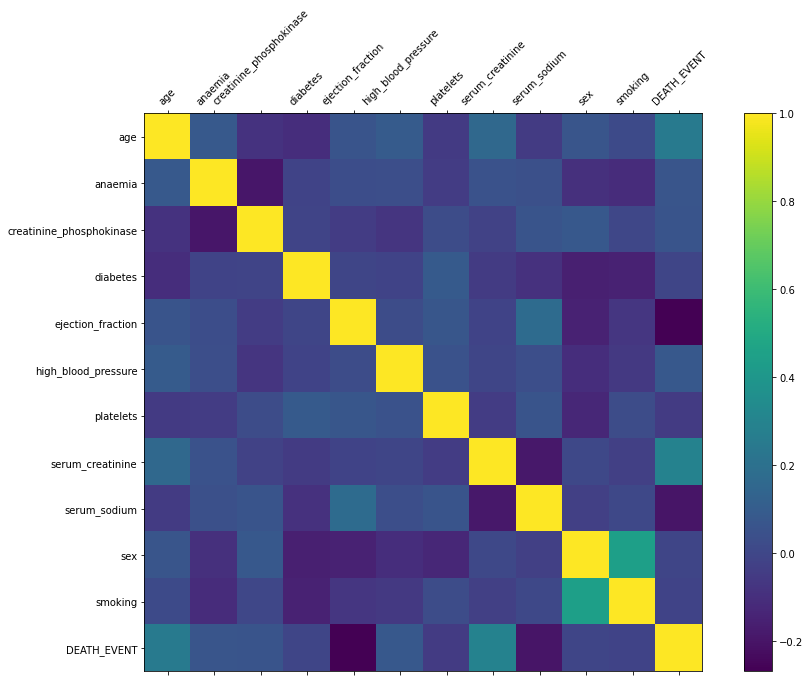

In [32]:
#df = df.drop(['time'], axis=1)
f = plt.figure(figsize=(15, 10))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=10, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

# Limpeza de Dados

Sem necessidade de limpeza dos dados

In [48]:
#limpeza dos dados (outlier)

fig = px.box(heart_failure, y='age', x="DEATH_EVENT", points="all",color="sex")
fig.show()

In [50]:
#ejection_fraction
#serum_creatinine
fig = px.box(heart_failure, y='ejection_fraction', x="DEATH_EVENT", points="all",color="sex")
fig.show()

In [ ]:
#checar necessidade de balanceamento

In [34]:
#definir features

In [55]:
#testes: PCA / normalização
heart_failure_target = heart_failure.DEATH_EVENT
heart_failure_feature = heart_failure.drop(['DEATH_EVENT','time'],axis=1)

In [56]:
heart_failure_feature.head(3)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1


In [58]:
#Normalização dos dados
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(heart_failure_feature.values) # normalizing the features
scaled_features_df = pd.DataFrame(x, index=heart_failure_feature.index, columns=heart_failure_feature.columns)

scaled_features_df.head(4)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682


In [59]:
import numpy as np

np.mean(scaled_features_df),np.std(scaled_features_df)

(age                         5.265205e-16
 anaemia                     3.594301e-16
 creatinine_phosphokinase    3.713120e-18
 diabetes                    1.113936e-16
 ejection_fraction           3.341808e-18
 high_blood_pressure        -4.841909e-16
 platelets                   1.009969e-16
 serum_creatinine           -2.227872e-18
 serum_sodium               -8.627435e-16
 sex                        -5.940993e-18
 smoking                    -3.861645e-17
 dtype: float64, age                         1.0
 anaemia                     1.0
 creatinine_phosphokinase    1.0
 diabetes                    1.0
 ejection_fraction           1.0
 high_blood_pressure         1.0
 platelets                   1.0
 serum_creatinine            1.0
 serum_sodium                1.0
 sex                         1.0
 smoking                     1.0
 dtype: float64)

In [72]:
from sklearn.decomposition import PCA

pca_heart = PCA(n_components=.80)
principalComponents = pca_heart.fit_transform(scaled_features_df)
principalComponents_df = pd.DataFrame(principalComponents,index =scaled_features_df.index)

principalComponents_df.head(4)

,0,1,2,3,4,5,6,7
0,0.869768,1.462919,1.018310,1.156098,-0.523452,-1.818766,0.066648,-0.270048
1,1.866471,-3.427661,1.223808,2.646201,4.261745,-1.596060,1.848073,2.201242
2,2.521889,0.881022,1.255749,-0.534283,-0.387760,-0.267889,-0.467260,-0.742793
3,0.575683,0.682327,0.592338,-1.690663,0.408138,-0.209260,1.532966,-0.362973


In [73]:
principalComponents_df.shape
#pesquisar como apresentar nome das variáveis

(299, 8)

In [75]:
#Divisão dos dados em teste e treino
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(principalComponents_df, heart_failure_target , test_size=0.3, random_state=337)


In [77]:
X_train.shape

(209, 8)

In [81]:
#Aplicação de modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import NearestCentroid
#from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.neural_network import MLPClassifier


def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame, target_names):
    
    dfs = []
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier()), 
          ('DECT', DecisionTreeClassifier()), 
          ('SGDC', SGDClassifier()), 
          ('NEAC', NearestCentroid()), 
          ('MLPC', MLPClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']#, 'roc_auc']
    
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred))#, target_names=target_names))
        results.append(cv_results)
        names.append(name)
    
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
            
    final = pd.concat(dfs, ignore_index=True)

    return final

In [82]:
#comparação de modelos
target = 'DEATH_EVENT'
run_exps(X_train, y_train, X_test, y_test, target)

LogReg
              precision    recall  f1-score   support

           0       0.72      0.88      0.79        59
           1       0.61      0.35      0.45        31

    accuracy                           0.70        90
   macro avg       0.67      0.62      0.62        90
weighted avg       0.68      0.70      0.68        90

RF
              precision    recall  f1-score   support

           0       0.72      0.92      0.81        59
           1       0.67      0.32      0.43        31

    accuracy                           0.71        90
   macro avg       0.69      0.62      0.62        90
weighted avg       0.70      0.71      0.68        90

KNN
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        59
           1       0.54      0.23      0.32        31

    accuracy                           0.67        90
   macro avg       0.61      0.56      0.55        90
weighted avg       0.64      0.67      0.62        90

SVM
 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iter

MLPC
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        59
           1       0.50      0.32      0.39        31

    accuracy                           0.66        90
   macro avg       0.60      0.58      0.58        90
weighted avg       0.63      0.66      0.63        90



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,model
0,0.012237,0.005613,0.738095,0.810119,0.738095,0.662940,LogReg
1,0.005544,0.004143,0.761905,0.764791,0.761905,0.744048,LogReg
2,0.004922,0.004155,0.642857,0.633850,0.642857,0.638021,LogReg
3,0.004950,0.004059,0.738095,0.721464,0.738095,0.717309,LogReg
4,0.005251,0.004366,0.682927,0.645522,0.682927,0.653789,LogReg
5,0.140928,0.010964,0.666667,0.625850,0.666667,0.632292,RF
6,0.141455,0.011042,0.738095,0.732143,0.738095,0.723002,RF
7,0.154717,0.011770,0.690476,0.698371,0.690476,0.694044,RF
8,0.150440,0.011791,0.714286,0.702076,0.714286,0.646008,RF
9,0.137392,0.012202,0.707317,0.707317,0.707317,0.707317,RF


In [ ]:
#Gráficos com Modelos: NearestCentroid, LogReg,  MLPClassifier

# NearestCentroid: Jessiele
# MLPClassifier: Clayton
# LogReg: Carol